In [ ]:
!pip install --quiet --upgrade ultralytics opencv-python

In [ ]:
!pip uninstall -y ultralytics -q
!pip install -q git+https://github.com/ultralytics/ultralytics.git

In [ ]:
!pip install -q --no-cache-dir torchvision==0.18.0

In [ ]:
import torch, importlib
DetectionModel = importlib.import_module("ultralytics.nn.tasks").DetectionModel
torch.serialization.add_safe_globals({'ultralytics.nn.tasks.DetectionModel': DetectionModel})

In [ ]:
pip uninstall -y torch torchvision torchaudio torchtext torchdata

In [ ]:
!pip install --no-cache-dir --extra-index-url https://download.pytorch.org/whl/cpu \
            torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0

In [ ]:
%%writefile /kaggle/working/mask.yaml
# YOLOv8 data configuration
# (assumes you converted the VOC dataset into /kaggle/working/face_mask_yolo)

path: /kaggle/working/face_mask_yolo   # dataset root
train: images/train                    # sub-folder created by `yolo data split`
val:   images/val
test:  images/test                     # optional but nice to have

names:
  0: with_mask
  1: without_mask
  2: mask_weared_incorrect

In [ ]:
!find /kaggle/working/face_mask_yolo -maxdepth 2 -type d -print

In [ ]:
import pathlib, shutil, random

ROOT = pathlib.Path("/kaggle/working/face_mask_yolo")   # adjust if needed
IMG_DIR = ROOT / "images"
LBL_DIR = ROOT / "labels"

# extensions to accept
EXTS = (".jpg", ".jpeg", ".png")

# make destination folders
for split in ("train", "val", "test"):
    (ROOT / f"images/{split}").mkdir(parents=True, exist_ok=True)
    (ROOT / f"labels/{split}").mkdir(parents=True, exist_ok=True)

TRAIN_P, VAL_P = 0.70, 0.15
random.seed(0)

all_imgs = [p for p in IMG_DIR.iterdir() if p.suffix.lower() in EXTS]
random.shuffle(all_imgs)

n = len(all_imgs)
if n == 0:
    raise RuntimeError(f"No images found in {IMG_DIR}. Check the path and extensions.")

n_train, n_val = int(n*TRAIN_P), int(n*VAL_P)

def move(img_path, split):
    lbl_path = LBL_DIR / f"{img_path.stem}.txt"
    if not lbl_path.exists():
        print("missing label for", img_path.name)
        return
    shutil.move(img_path, ROOT / f"images/{split}" / img_path.name)
    shutil.move(lbl_path, ROOT / f"labels/{split}" / lbl_path.name)

for i, img in enumerate(all_imgs):
    if i < n_train:
        move(img, "train")
    elif i < n_train + n_val:
        move(img, "val")
    else:
        move(img, "test")

print(f"Moved {n_train} train, {n_val} val, {n - n_train - n_val} test images")

In [ ]:
!yolo detect train model=yolov8n.pt data=/kaggle/working/mask.yaml epochs=30 imgsz=640

In [ ]:
!cp /kaggle/working/runs/detect/train2/weights/best.pt /kaggle/working/best_mask.pt

In [ ]:
from IPython.display import Image, display
display(Image('/kaggle/working/runs/detect/train2/results.png'))  

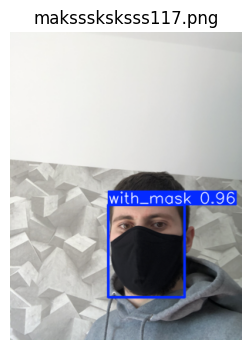

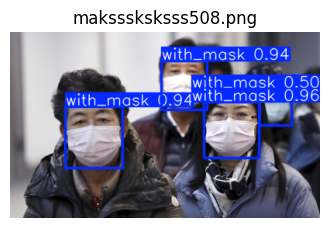

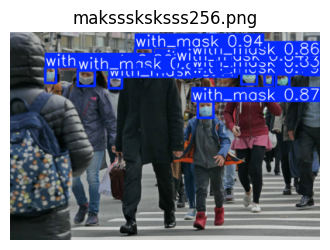

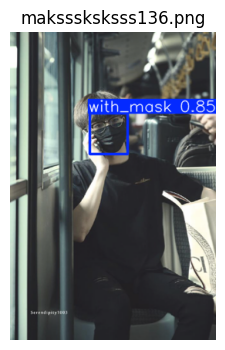

In [1]:
from ultralytics import YOLO
import cv2, matplotlib.pyplot as plt, glob, random, pathlib

model = YOLO('/kaggle/working/runs/detect/train2/weights/best.pt')  # adjust if needed
val_imgs = glob.glob('/kaggle/working/face_mask_yolo/images/val/*')

for img_path in random.sample(val_imgs, 4):
    res = model.predict(img_path, conf=0.35, verbose=False)[0]
    img = cv2.cvtColor(res.plot(), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(pathlib.Path(img_path).name)
    plt.axis('off')
    plt.show()
